# 08 LGBM Forecast

In [21]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

from typing import List, Tuple
from pandas import DataFrame, Series

import shap

import warnings
warnings.filterwarnings("ignore")

In [22]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# widen the column width and overall display width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

In [23]:
TRAIN_PATH: str = "../data/interim/train.csv"
FORECAST_PATH: str = "../data/interim/forecast.csv"
TARGET_COL: str = "use_house_overall"

In [24]:
train_df: DataFrame = pd.read_csv(TRAIN_PATH, index_col="time", parse_dates=True)
forecast_df: DataFrame = pd.read_csv(FORECAST_PATH, index_col="time", parse_dates=True)

train_df = train_df.select_dtypes(include="number")
forecast_df = forecast_df[train_df.columns]

In [25]:
# --- Hyperparameter tuning with Optuna ---
X_train: DataFrame = train_df[[col for col in train_df.columns if col != TARGET_COL]]
y_train: Series = train_df[TARGET_COL]

def objective(trial: optuna.Trial) -> float:
    param = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 32, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        "seed": 42,
        "verbosity": -1
    }

    tscv = TimeSeriesSplit(n_splits=3)
    mae_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            param,
            train_set=dtrain,
            valid_sets=[dval],
            callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0) ]
        )

        preds = model.predict(X_val)
        score = mean_absolute_error(y_val, preds)
        mae_scores.append(score)

    return np.mean(mae_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params: dict = study.best_trial.params
print("Best parameters found by Optuna:", best_params)

[I 2025-06-05 19:31:18,549] A new study created in memory with name: no-name-0b1abf23-0372-4749-a118-0f214ce4a30c
[I 2025-06-05 19:31:18,619] Trial 0 finished with value: 0.339047192211049 and parameters: {'learning_rate': 0.11817140324128615, 'num_leaves': 73, 'feature_fraction': 0.849752162881894, 'bagging_fraction': 0.8550786207843195, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 0 with value: 0.339047192211049.
[I 2025-06-05 19:31:18,694] Trial 1 finished with value: 0.3386809344081419 and parameters: {'learning_rate': 0.1580195214869778, 'num_leaves': 36, 'feature_fraction': 0.9971972583440459, 'bagging_fraction': 0.7619668014080193, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 1 with value: 0.3386809344081419.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.30248
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.301381
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[

[I 2025-06-05 19:31:18,832] Trial 2 finished with value: 0.2795849610045433 and parameters: {'learning_rate': 0.06950572814422776, 'num_leaves': 116, 'feature_fraction': 0.7790704661103902, 'bagging_fraction': 0.9791629011182155, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 2 with value: 0.2795849610045433.
[I 2025-06-05 19:31:18,906] Trial 3 finished with value: 0.33390184495477593 and parameters: {'learning_rate': 0.09976484838672744, 'num_leaves': 249, 'feature_fraction': 0.6300152144460017, 'bagging_fraction': 0.6109831704227909, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 2 with value: 0.2795849610045433.
[I 2025-06-05 19:31:19,014] Trial 4 finished with value: 0.27036898343458815 and parameters: {'learning_rate': 0.15078402265013538, 'num_leaves': 84, 'feature_fraction': 0.9968112496773707, 'bagging_fraction': 0.672018998415698, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 4 with value: 0.27036898343458815.


Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.245339
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's l1: 0.287044
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 0.290416
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's l1: 0.24017
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:19,146] Trial 5 finished with value: 0.24088546737082941 and parameters: {'learning_rate': 0.19496018781556404, 'num_leaves': 177, 'feature_fraction': 0.8791604171117445, 'bagging_fraction': 0.6319774009214957, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 5 with value: 0.24088546737082941.


Early stopping, best iteration is:
[34]	valid_0's l1: 0.164996
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 0.289778
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 0.250683
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's l1: 0.148158
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:19,336] Trial 6 finished with value: 0.24545776802709116 and parameters: {'learning_rate': 0.12428475902041981, 'num_leaves': 84, 'feature_fraction': 0.8430854474132069, 'bagging_fraction': 0.7920566244898052, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 5 with value: 0.24088546737082941.


Early stopping, best iteration is:
[72]	valid_0's l1: 0.27184
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 0.313321
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.12806
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:19,702] Trial 7 finished with value: 0.20798318925140014 and parameters: {'learning_rate': 0.06674511174237058, 'num_leaves': 131, 'feature_fraction': 0.9793444294025775, 'bagging_fraction': 0.9488983262464048, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 7 with value: 0.20798318925140014.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.273599
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.222291
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:19,739] Trial 8 finished with value: 0.3887006096083703 and parameters: {'learning_rate': 0.10501085771465206, 'num_leaves': 207, 'feature_fraction': 0.9667109579036106, 'bagging_fraction': 0.621769409752161, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 7 with value: 0.20798318925140014.
[I 2025-06-05 19:31:19,809] Trial 9 finished with value: 0.3473871084898617 and parameters: {'learning_rate': 0.08976220002818404, 'num_leaves': 243, 'feature_fraction': 0.6823775308179792, 'bagging_fraction': 0.6938715612447656, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 7 with value: 0.20798318925140014.


Early stopping, best iteration is:
[25]	valid_0's l1: 0.45144
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.3275
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.178022
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:20,233] Trial 10 finished with value: 0.26059913543199525 and parameters: {'learning_rate': 0.014081295940145414, 'num_leaves': 148, 'feature_fraction': 0.7438798061647902, 'bagging_fraction': 0.9962772786657015, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 7 with value: 0.20798318925140014.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.315797
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.287979
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 0.128903
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 0.302438
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:20,458] Trial 11 finished with value: 0.22796053356842141 and parameters: {'learning_rate': 0.19504452567664662, 'num_leaves': 166, 'feature_fraction': 0.9057421545857102, 'bagging_fraction': 0.8977459647116746, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 7 with value: 0.20798318925140014.


Early stopping, best iteration is:
[75]	valid_0's l1: 0.251935
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.279235
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.311072
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:20,687] Trial 12 finished with value: 0.28632260035522544 and parameters: {'learning_rate': 0.046872539105663025, 'num_leaves': 151, 'feature_fraction': 0.9232409534232419, 'bagging_fraction': 0.90312598290852, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 7 with value: 0.20798318925140014.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.26866
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.117024
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.28124
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:21,169] Trial 13 finished with value: 0.20621687807944897 and parameters: {'learning_rate': 0.039209808398928056, 'num_leaves': 193, 'feature_fraction': 0.9235467848699471, 'bagging_fraction': 0.9192852666849783, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 13 with value: 0.20621687807944897.


Did not meet early stopping. Best iteration is:
[95]	valid_0's l1: 0.220386
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.141428
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.281688
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:21,522] Trial 14 finished with value: 0.2265293875708194 and parameters: {'learning_rate': 0.0340534311271396, 'num_leaves': 200, 'feature_fraction': 0.9279412282730972, 'bagging_fraction': 0.930178588816179, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 13 with value: 0.20621687807944897.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.256472
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's l1: 0.105699
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:21,949] Trial 15 finished with value: 0.20097843019901293 and parameters: {'learning_rate': 0.06439667478948713, 'num_leaves': 118, 'feature_fraction': 0.9563385607740914, 'bagging_fraction': 0.8436069161053855, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.272881
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's l1: 0.224355
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.145167
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.300356
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:22,400] Trial 16 finished with value: 0.23681419018307012 and parameters: {'learning_rate': 0.02196312304218794, 'num_leaves': 212, 'feature_fraction': 0.805122691940581, 'bagging_fraction': 0.8397510154616494, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.264919
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's l1: 0.217399
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.29993
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:22,612] Trial 17 finished with value: 0.2620194973561765 and parameters: {'learning_rate': 0.06078748003566434, 'num_leaves': 117, 'feature_fraction': 0.9384569217757426, 'bagging_fraction': 0.8450585723977817, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 15 with value: 0.20097843019901293.
[I 2025-06-05 19:31:22,748] Trial 18 finished with value: 0.29945877790787645 and parameters: {'learning_rate': 0.03966471744980994, 'num_leaves': 184, 'feature_fraction': 0.8778250606616195, 'bagging_fraction': 0.7512287597337923, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.26873
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.32824
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's l1: 0.290422
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's l1: 0.163515
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:22,956] Trial 19 finished with value: 0.23744384333881804 and parameters: {'learning_rate': 0.08410206024458487, 'num_leaves': 224, 'feature_fraction': 0.7283275310944661, 'bagging_fraction': 0.8855631568903138, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[85]	valid_0's l1: 0.29947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.249141
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.129159
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:23,339] Trial 20 finished with value: 0.22665319200806042 and parameters: {'learning_rate': 0.05415048325496637, 'num_leaves': 105, 'feature_fraction': 0.8293220818251535, 'bagging_fraction': 0.8116426925917396, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.271509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.279292
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.128931
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's l1: 0.278308
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:23,680] Trial 21 finished with value: 0.21330504463855005 and parameters: {'learning_rate': 0.07494365264476036, 'num_leaves': 134, 'feature_fraction': 0.9619690060133307, 'bagging_fraction': 0.953325144265811, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.232676
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.146441
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.289137
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:24,039] Trial 22 finished with value: 0.22603611317508246 and parameters: {'learning_rate': 0.032200627437923804, 'num_leaves': 133, 'feature_fraction': 0.959666720978533, 'bagging_fraction': 0.9338483380448823, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.242531
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.1426
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.293085
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:24,290] Trial 23 finished with value: 0.23276089878115602 and parameters: {'learning_rate': 0.05953914302632886, 'num_leaves': 162, 'feature_fraction': 0.9989688329796044, 'bagging_fraction': 0.9580202819920114, 'bagging_freq': 1, 'min_child_samples': 11}. Best is trial 15 with value: 0.20097843019901293.


Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.262598
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.105026
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:24,692] Trial 24 finished with value: 0.2004880038975064 and parameters: {'learning_rate': 0.06742991668560899, 'num_leaves': 64, 'feature_fraction': 0.8891817763641164, 'bagging_fraction': 0.8788734141228207, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 24 with value: 0.2004880038975064.


Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.26633
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 0.230108
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.16611
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.326927
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:25,129] Trial 25 finished with value: 0.26153878456282176 and parameters: {'learning_rate': 0.011753623425093403, 'num_leaves': 33, 'feature_fraction': 0.8893491291419309, 'bagging_fraction': 0.8713819979820163, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 24 with value: 0.2004880038975064.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.291579
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's l1: 0.16082
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.291847
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:25,383] Trial 26 finished with value: 0.2501116407924168 and parameters: {'learning_rate': 0.04732651267163158, 'num_leaves': 69, 'feature_fraction': 0.8663305743871055, 'bagging_fraction': 0.8050520512241688, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 24 with value: 0.2004880038975064.
[I 2025-06-05 19:31:25,549] Trial 27 finished with value: 0.2788045130959951 and parameters: {'learning_rate': 0.07834744997486888, 'num_leaves': 61, 'feature_fraction': 0.9078167028862135, 'bagging_fraction': 0.9165777993549108, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 24 with value: 0.2004880038975064.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.297087
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.293755
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.262944
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:25,668] Trial 28 finished with value: 0.32841639869941025 and parameters: {'learning_rate': 0.02442484570214115, 'num_leaves': 106, 'feature_fraction': 0.9418863719767584, 'bagging_fraction': 0.7556279697387291, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 24 with value: 0.2004880038975064.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.360481
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.345054
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 0.10479
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 0.281189
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 19:31:25,924] Trial 29 finished with value: 0.21285681722684238 and parameters: {'learning_rate': 0.1159937090534014, 'num_leaves': 52, 'feature_fraction': 0.8175196745818974, 'bagging_fraction': 0.8622912867822853, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 24 with value: 0.2004880038975064.


Did not meet early stopping. Best iteration is:
[83]	valid_0's l1: 0.252592
Best parameters found by Optuna: {'learning_rate': 0.06742991668560899, 'num_leaves': 64, 'feature_fraction': 0.8891817763641164, 'bagging_fraction': 0.8788734141228207, 'bagging_freq': 2, 'min_child_samples': 5}


In [26]:
def train_lgbm_forecast(
    train_df: DataFrame,
    forecast_df: DataFrame,
    features: List[str],
    target: str
) -> Tuple[DataFrame, lgb.Booster, DataFrame]:
    """
    Train LightGBM on time series data and forecast the next horizon.
    """
    X_train: DataFrame = train_df[features]
    y_train: Series = train_df[target]
    X_test: DataFrame = forecast_df[features]

    dtrain = lgb.Dataset(X_train, label=y_train)

    params: dict = {
        **best_params
    }

    model: lgb.Booster = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=300
    )

    preds: np.ndarray = model.predict(X_test)
    pred_df: DataFrame = pd.DataFrame({target: preds}, index=forecast_df.index)

    return pred_df, model, X_train

In [27]:
# Run forecast on training
feature_cols: List[str] = [col for col in train_df.columns if col != TARGET_COL]
forecast_df_pred, model, X_train = train_lgbm_forecast(train_df, forecast_df, feature_cols, TARGET_COL)

In [28]:
# Evaluate on holdout data
actual: Series = forecast_df[TARGET_COL]
predicted: Series = forecast_df_pred[TARGET_COL]
mae: float = mean_absolute_error(actual, predicted)
print(f"LGBM MAE ({TARGET_COL}): {mae:.4f}")

LGBM MAE (use_house_overall): 0.0680


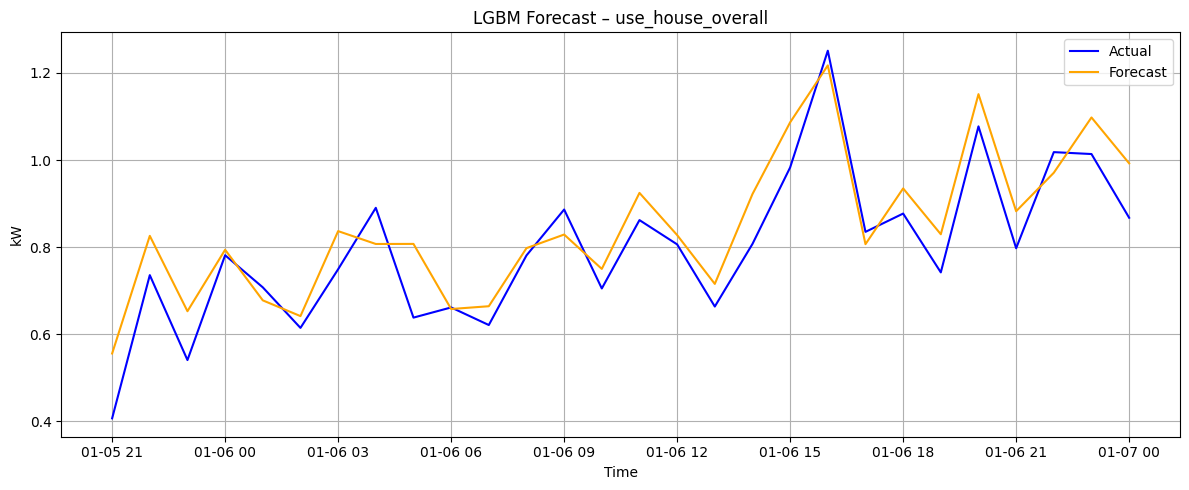

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual", color="blue")
plt.plot(predicted, label="Forecast", color="orange")
plt.title(f"LGBM Forecast – {TARGET_COL}")
plt.xlabel("Time")
plt.ylabel("kW")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The LightGBM model achieves a strong MAE of 0.0680 kW on hourly energy consumption forecasts, significantly outperforming the VAR baseline. Given the typical consumption range, this translates to a low relative error and offers a solid baseline for short-term prediction. In practical terms, it enables reliable demand forecasting for smart energy management, helping optimize consumption, reduce costs, and support better integration of renewable energy in households.

## Model explainer

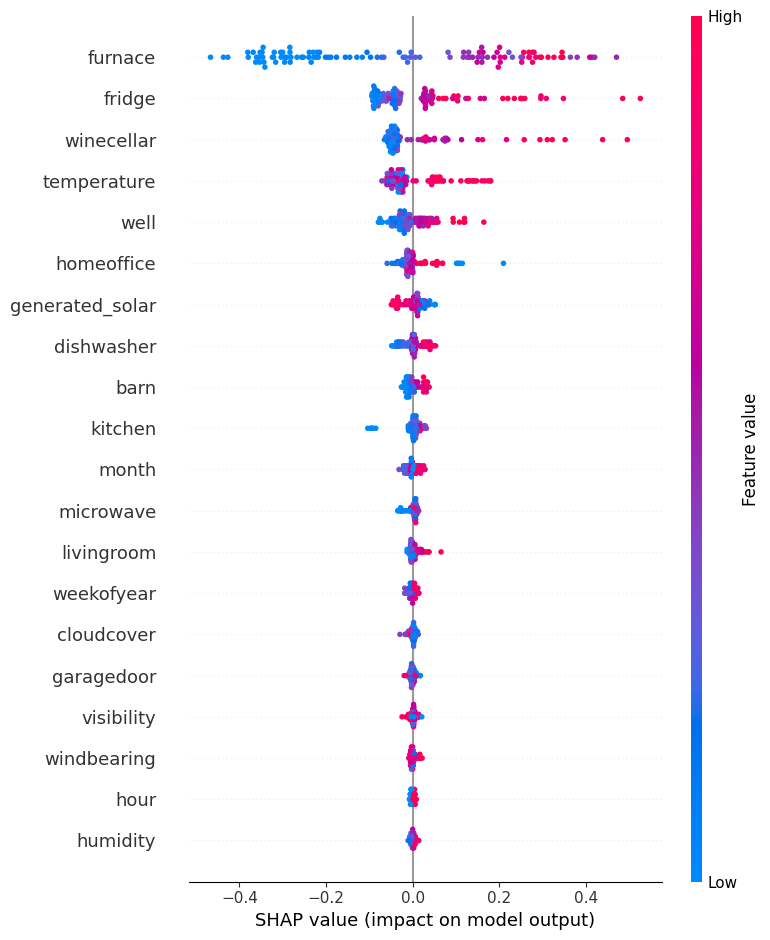

In [30]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show=False)
plt.tight_layout()
plt.show()

SHAP values were used to interpret the LightGBM model's predictions and understand the impact of each feature on energy consumption. This plot shows that appliances like the furnace, fridge, and wine cellar had the strongest influence, aligning with expected high-consumption devices. We included SHAP to ensure the model's decisions are transparent, interpretable, and aligned with domain knowledge, which is essential when aiming for actionable insights in real-world energy optimization.